In [1]:
import os
import sys
import json
import pickle
import matplotlib.pyplot as plt
import pandas as pd

# Switch to parent path to import local module
parent_path = str(os.getcwd()).split('notebooks')[0] # zeosyn_gen
os.chdir(parent_path)
print('Switched directory to:', os.getcwd())

import torch
import data.utils as utils
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory
from eval import load_model, get_prediction_and_ground_truths, eval_zeolite_aggregated, eval_zeolite_osda, plot_single_system
from data.metrics import maximum_mean_discrepancy, wasserstein_distance
from models.diffusion import *

plt.rc('font', family='Helvetica')

Switched directory to: /home/jupyter/Elton/Zeolites/zeosyn_gen


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
zeo, osda = 'ATO', 'CCCNCCC'

In [3]:
model_type = 'diff'
fname = 'v3'
split = 'system'

# Load configs
with open(f'runs/{model_type}/{split}/{fname}/configs.json') as f:
    configs = json.load(f)
with open(f"runs/{model_type}/{split}/{fname}/train_loss_list.pkl", 'rb') as f: # load dataset
    train_loss_list = pickle.load(f)
with open(f"runs/{model_type}/{split}/{fname}/val_loss_list.pkl", 'rb') as f: # load dataset
    val_loss_list = pickle.load(f)

model, configs = load_model(model_type, fname, split)
syn_pred, syn_pred_scaled, syn_true, syn_true_scaled, dataset = get_prediction_and_ground_truths(model, configs, cond_scale=0.75)

Loading model and configs...
Getting model predictions and grouth truths...
SYSTEMS:
train+val: 1856 test: 464

n_datapoints:
train: 14749 val: 2107 test: 5168
Loading synthetic predictions from saved predictions...


ATO CCCNCCC


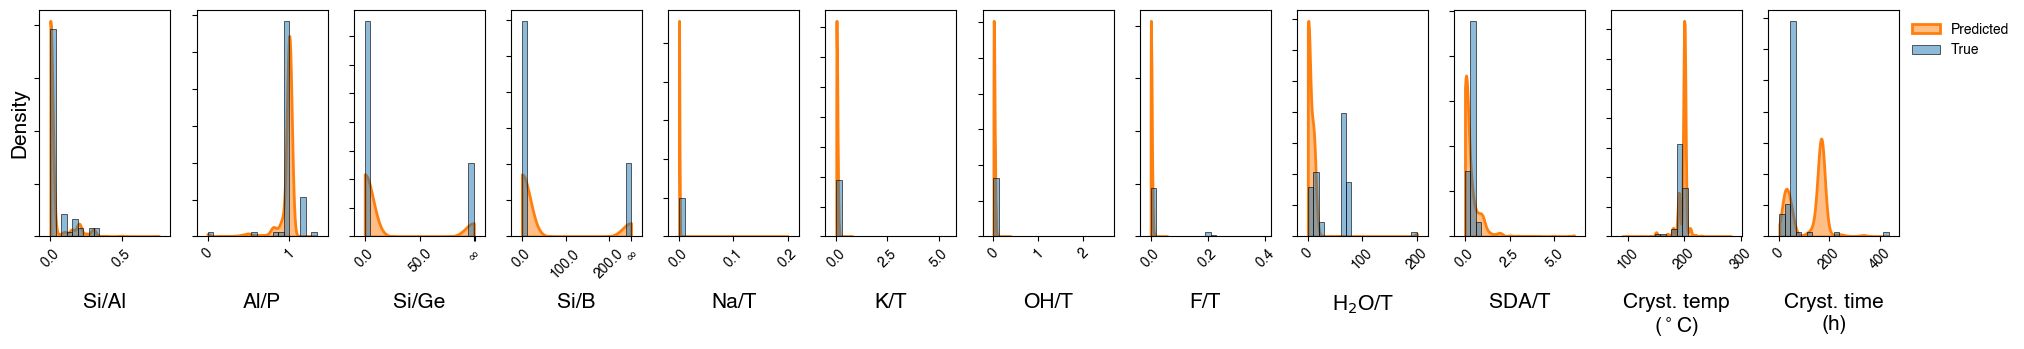

In [4]:
plot_single_system(syn_pred, syn_true, zeo=zeo, osda=osda)

In [5]:
pred, true = syn_pred[(syn_pred['zeo'] == zeo) & (syn_pred['osda'] == osda)], syn_true[(syn_true['zeo'] == zeo) & (syn_true['osda'] == osda)]

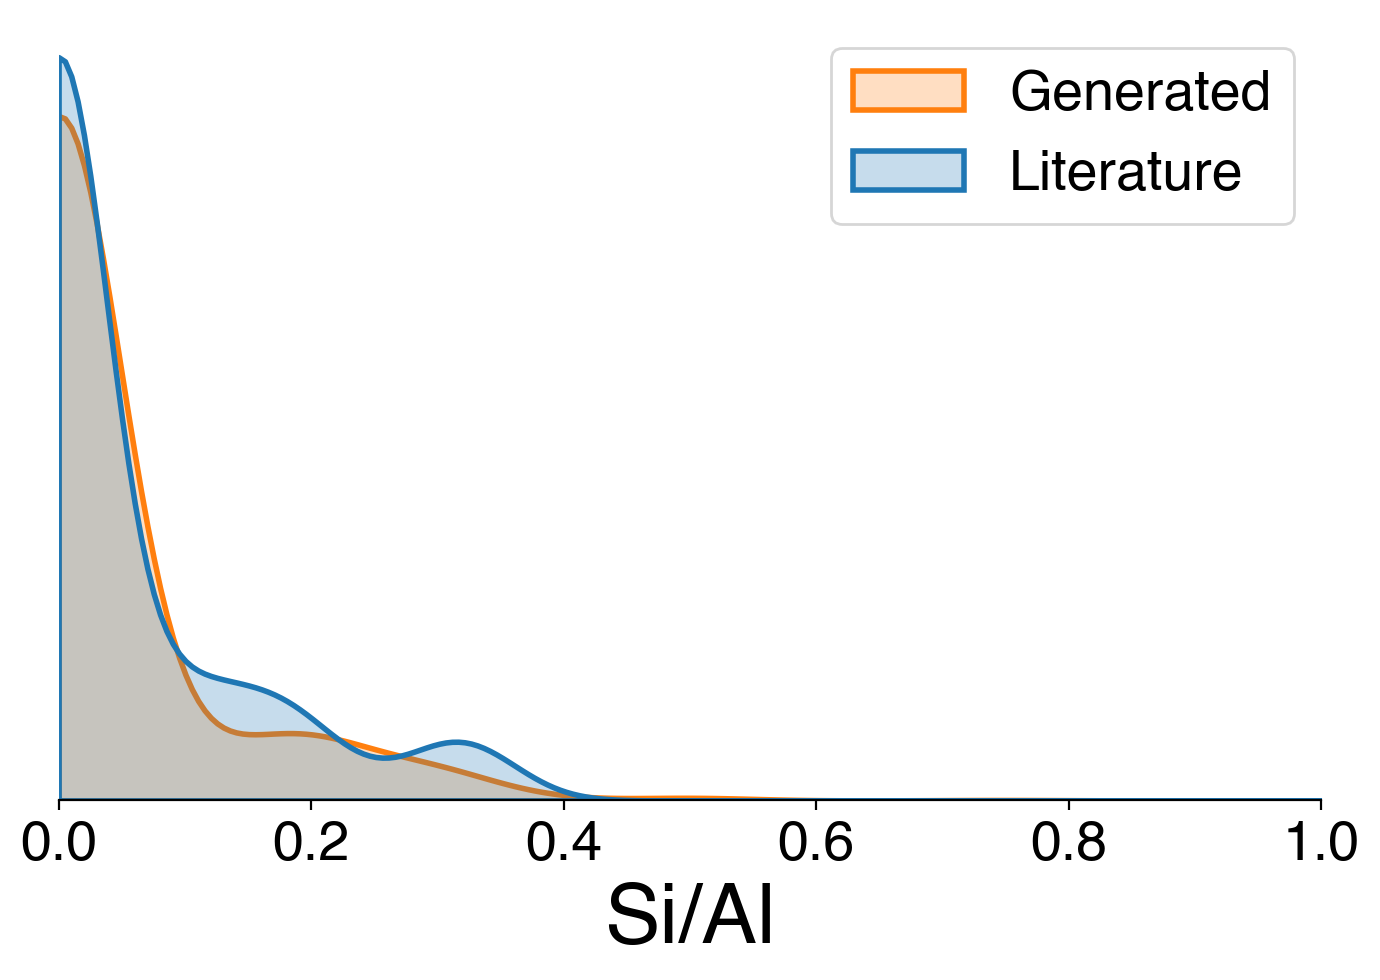

In [6]:
fig = plt.figure(figsize=(7, 5), dpi=200)

# Add subplots
xlim = (0, 1.)
sns.kdeplot(pred['Si/Al'], label='Generated', fill=True, bw_adjust=3., color='tab:orange', clip=xlim, cut=100, linewidth=2)
# sns.histplot(true['Si/Al'], label='Literature', bins=50, binrange=xlim, stat='density')
sns.kdeplot(true['Si/Al'], label='Literature', fill=True, bw_adjust=1., color='tab:blue',  clip=xlim, cut=100, linewidth=2)
plt.legend(loc='upper right', fontsize=20, frameon=True)
plt.xlim(*xlim)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Si/Al', fontsize=30)
plt.ylabel('Density', fontsize=30)
ax = plt.gca()
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.savefig(f'figs/CS6/SiAl.pdf', dpi=200, bbox_inches='tight')
plt.show()

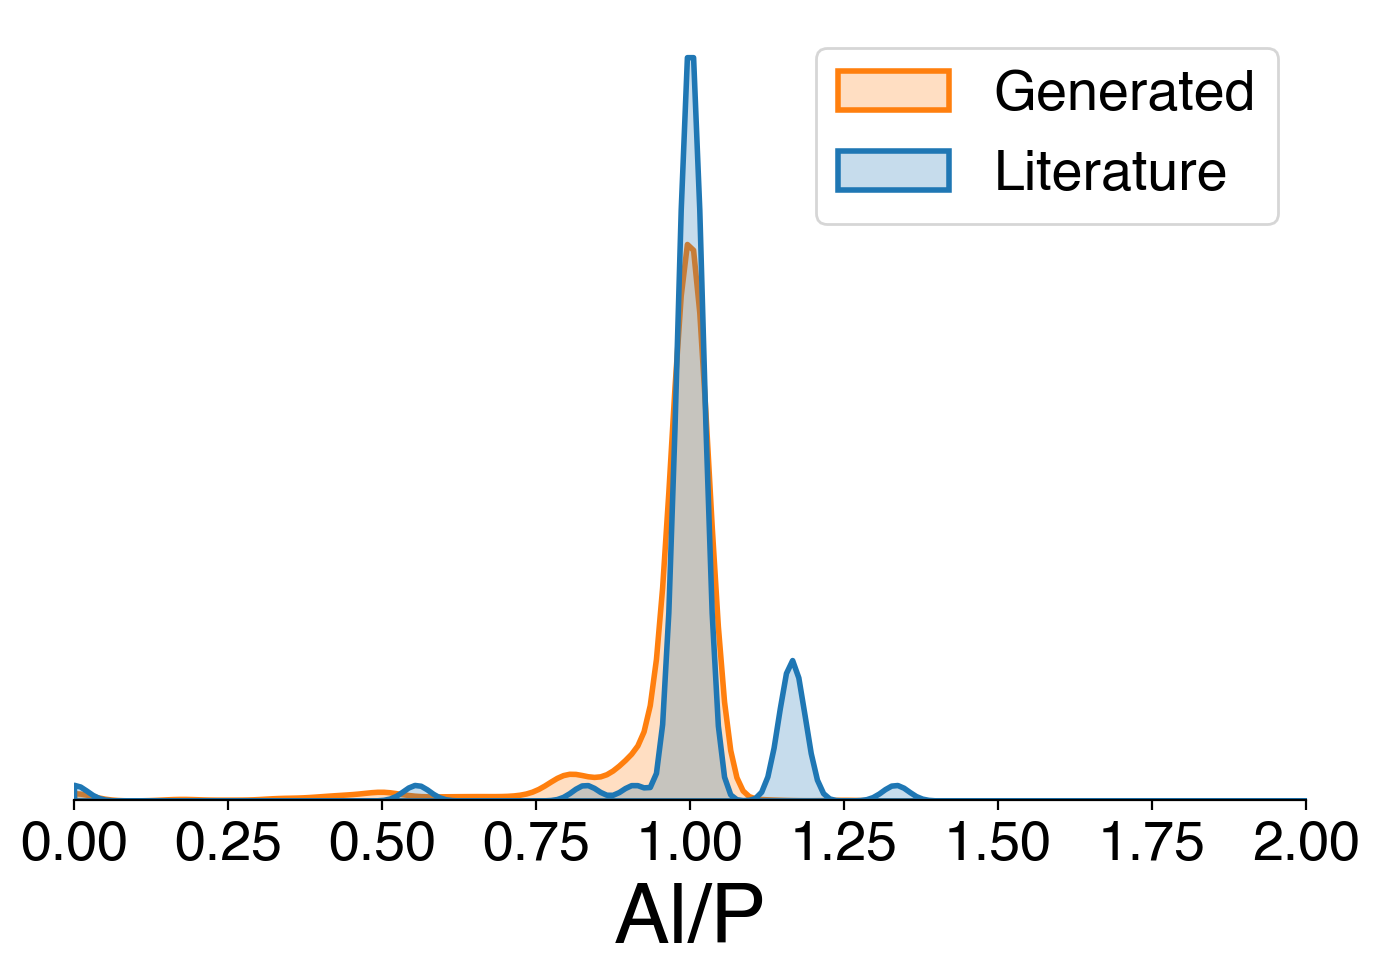

In [7]:
fig = plt.figure(figsize=(7, 5), dpi=200)

# Add subplots
xlim = (0, 2.)
sns.kdeplot(pred['Al/P'], label='Generated', fill=True, bw_adjust=1., color='tab:orange', clip=xlim, cut=100, linewidth=2)
# sns.histplot(true['Si/Al'], label='Literature', bins=50, binrange=xlim, stat='density')
sns.kdeplot(true['Al/P'], label='Literature', fill=True, bw_adjust=0.3, color='tab:blue',  clip=xlim, cut=100, linewidth=2)
plt.legend(loc='upper right', fontsize=20, frameon=True)
plt.xlim(*xlim)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Al/P', fontsize=30)
plt.ylabel('Density', fontsize=30)
ax = plt.gca()
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.savefig(f'figs/CS6/AlP.pdf', dpi=200, bbox_inches='tight')
plt.show()

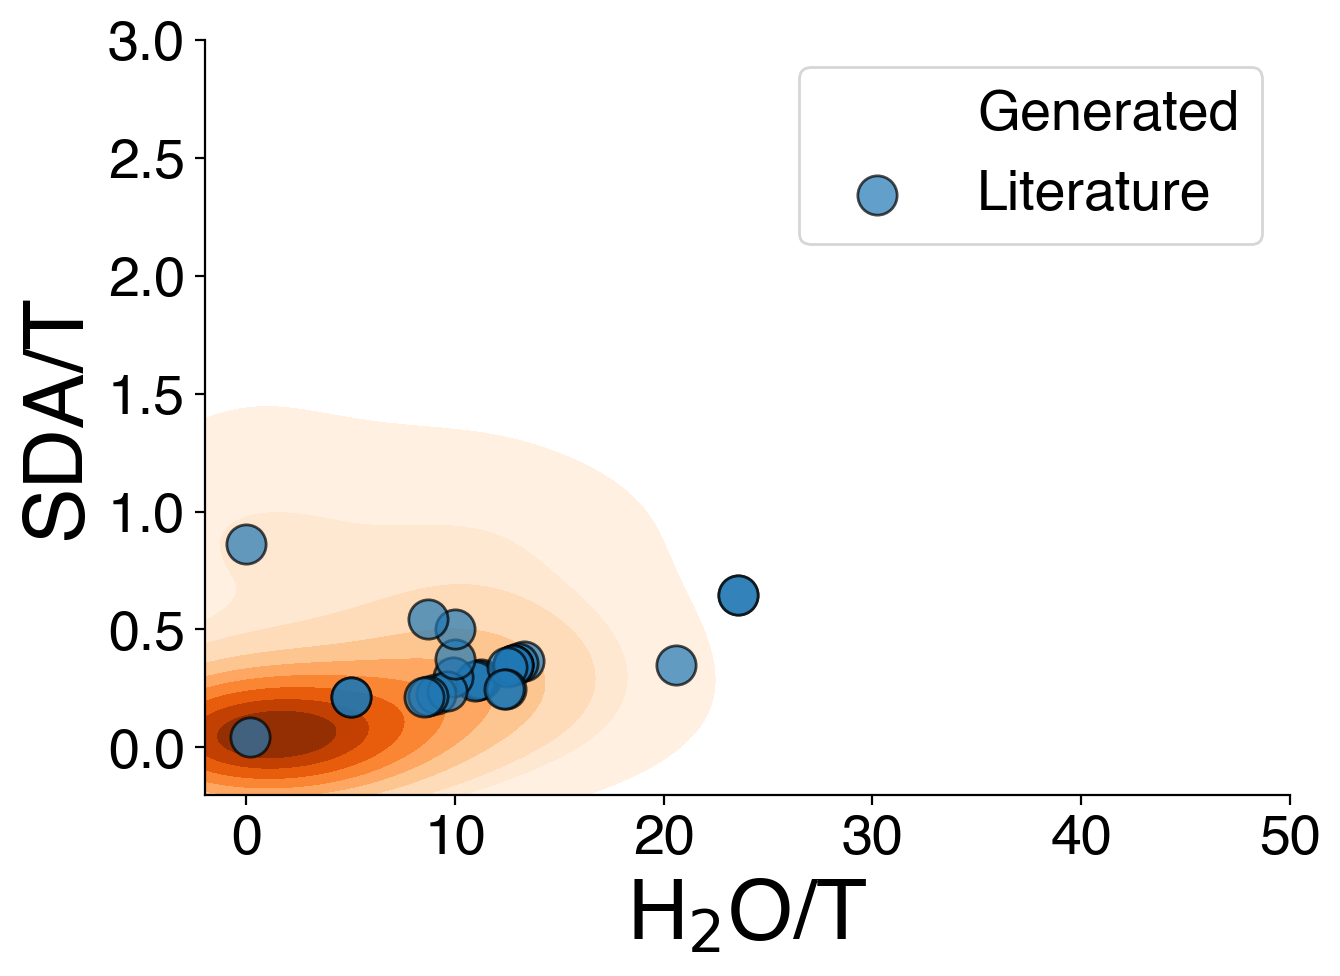

In [8]:
xlim = (-2, 50)
ylim = (-0.2, 3.)

fig = plt.figure(figsize=(7, 5), dpi=200)
sns.kdeplot(data=pred, x='H2O/T', y='sda1/T', fill=True, cmap='Oranges', alpha=1, label='Generated', bw_adjust=1, clip=(xlim, ylim))
plt.scatter(true['H2O/T'], true['sda1/T'], color='tab:blue', s=200, alpha=0.7, marker='o', edgecolor='black', label='Literature')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('H$_2$O/T', fontsize=30)
plt.ylabel('SDA/T', fontsize=30)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.legend(loc='upper right', fontsize=20, frameon=True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(f'figs/CS6/SDA-H2O.pdf', dpi=200, bbox_inches='tight')

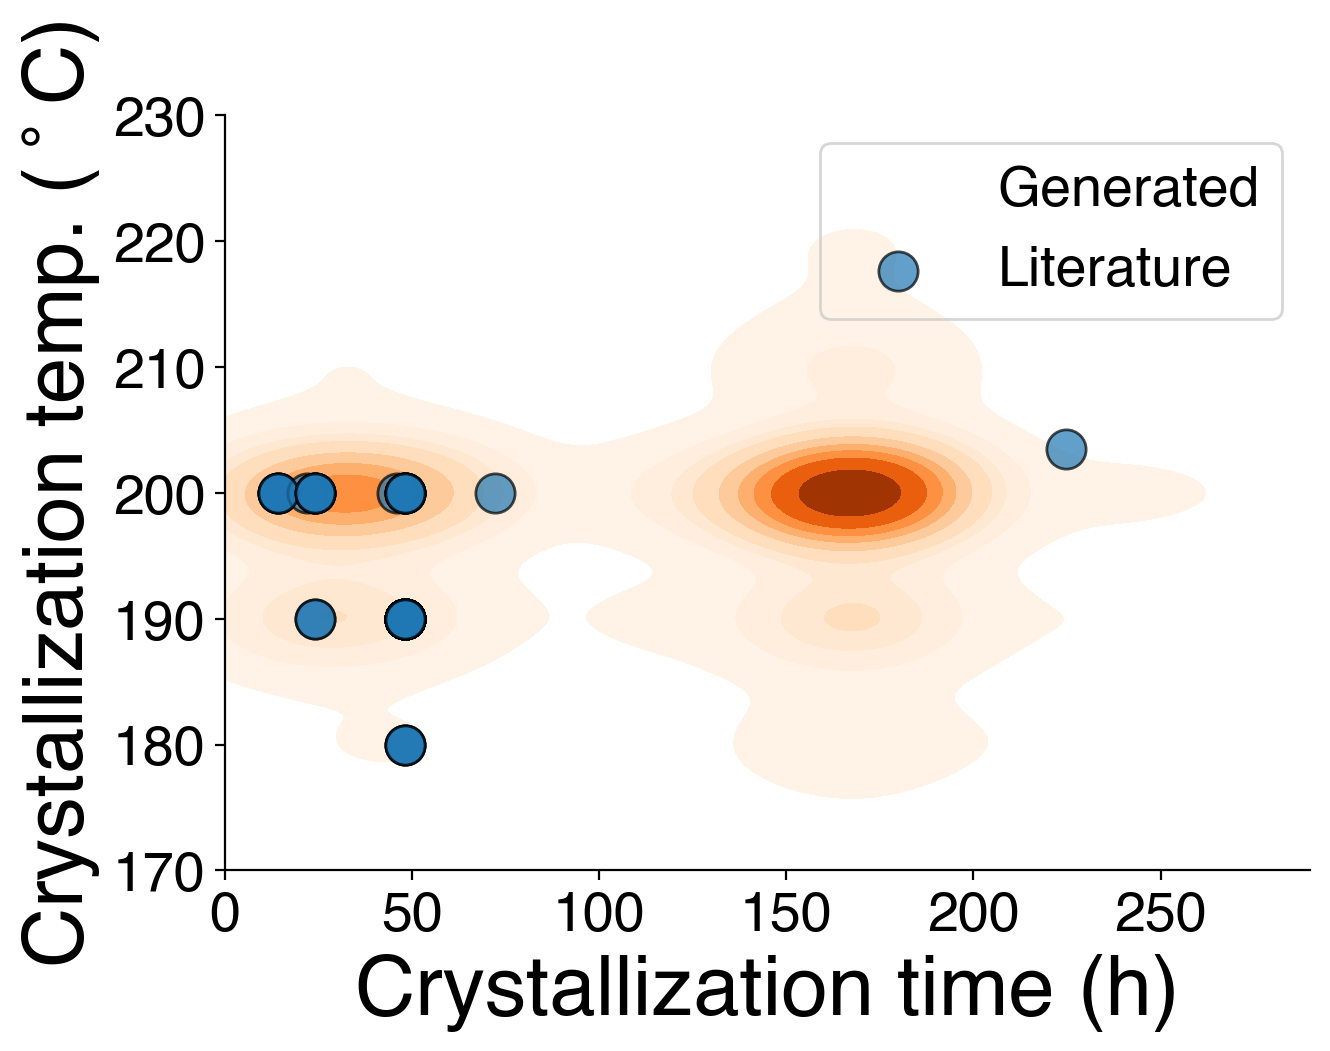

In [9]:
xlim = (0., 290)
ylim = (170., 230)

fig = plt.figure(figsize=(7, 5), dpi=200)
sns.kdeplot(data=pred, x='cryst_time', y='cryst_temp', fill=True, cmap='Oranges', alpha=1, label='Generated', bw_adjust=1, clip=(xlim, ylim))
plt.scatter(true['cryst_time'], true['cryst_temp'], color='tab:blue', s=200, alpha=0.7, marker='o', edgecolor='black', label='Literature')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Crystallization time (h)', fontsize=30)
plt.ylabel('Crystallization temp. ($^\circ$C)', fontsize=30)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.legend(loc='upper right', fontsize=20, frameon=True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(f'figs/CS6/temp-time.pdf', dpi=200, bbox_inches='tight')